# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Human Value Detection, Multi-label classification, Transformers, BERT


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are tasked to address the [Human Value Detection challenge](https://aclanthology.org/2022.acl-long.306/).

## Problem definition

Arguments are paired with their conveyed human values.

Arguments are in the form of **premise** $\rightarrow$ **conclusion**.

### Example:

**Premise**: *``fast food should be banned because it is really bad for your health and is costly''*

**Conclusion**: *``We should ban fast food''*

**Stance**: *in favour of*

<center>
    <img src="./images/human_values.png" alt="human values" />
</center>

In [1]:
!pip install transformers

In [3]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from transformers import RobertaTokenizer, RobertaModel
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings('ignore')

# [Task 1 - 0.5 points] Corpus

Check the official page of the challenge [here](https://touche.webis.de/semeval23/touche23-web/).

The challenge offers several corpora for evaluation and testing.

You are going to work with the standard training, validation, and test splits.

#### Arguments
* arguments-training.tsv
* arguments-validation.tsv
* arguments-test.tsv

#### Human values
* labels-training.tsv
* labels-validation.tsv
* labels-test.tsv

### Example

#### arguments-*.tsv
```

Argument ID    A01005

Conclusion     We should ban fast food

Stance         in favor of

Premise        fast food should be banned because it is really bad for your health and is costly.
```

#### labels-*.tsv

```
Argument ID                A01005

Self-direction: thought    0
Self-direction: action     0
...
Universalism: objectivity: 0
```

### Splits

The standard splits contain

   * **Train**: 5393 arguments
   * **Validation**: 1896 arguments
   * **Test**: 1576 arguments

### Annotations

In this assignment, you are tasked to address a multi-label classification problem.

You are going to consider **level 3** categories:

* Openness to change
* Self-enhancement
* Conversation
* Self-transcendence

**How to do that?**

You have to merge (**logical OR**) annotations of level 2 categories belonging to the same level 3 category.

**Pay attention to shared level 2 categories** (e.g., Hedonism). $\rightarrow$ [see Table 1 in the original paper.](https://aclanthology.org/2022.acl-long.306/)

#### Example

```
Self-direction: thought:    0
Self-direction: action:     1
Stimulation:                0
Hedonism:                   1

Openess to change           1
```

### Instructions

* **Download** the specificed training, validation, and test files.
* **Encode** split files into a pandas.DataFrame object.
* For each split, **merge** the arguments and labels dataframes into a single dataframe.
* **Merge** level 2 annotations to level 3 categories.

In [4]:
!mkdir data
!curl https://zenodo.org/records/8248658/files/arguments-training.tsv?download=1 -o data/arguments-training.tsv
!curl https://zenodo.org/records/8248658/files/arguments-validation.tsv?download=1 -o data/arguments-validation.tsv
!curl https://zenodo.org/records/8248658/files/arguments-test.tsv?download=1 -o data/arguments-test.tsv
!curl https://zenodo.org/records/8248658/files/labels-training.tsv?download=1 -o data/labels-training.tsv
!curl https://zenodo.org/records/8248658/files/labels-validation.tsv?download=1 -o data/labels-validation.tsv
!curl https://zenodo.org/records/8248658/files/labels-test.tsv?download=1 -o data/labels-test.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  988k  100  988k    0     0   641k      0  0:00:01  0:00:01 --:--:--  641k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  354k  100  354k    0     0   250k      0  0:00:01  0:00:01 --:--:--  250k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  283k  100  283k    0     0   202k      0  0:00:01  0:00:01 --:--:--  203k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  247k  100  247k    0     0   182k      0  0:00:01  0:00:01 --:--:--  182k
  % Total    % Received % Xferd  Average Speed   Tim

In [5]:
arguments_train = pd.read_csv('data/arguments-training.tsv', sep='\t')
arguments_val = pd.read_csv('data/arguments-validation.tsv', sep='\t')
arguments_test = pd.read_csv('data/arguments-test.tsv', sep='\t')
labels_train = pd.read_csv('data/labels-training.tsv', sep='\t')
labels_val = pd.read_csv('data/labels-validation.tsv', sep='\t')
labels_test = pd.read_csv('data/labels-test.tsv', sep='\t')

In [6]:
arguments_train.head()

,Argument ID,Conclusion,Stance,Premise
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...


In [7]:
labels_train.head()

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,A01006,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A01007,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0


In [8]:
print(labels_train.columns)

Index(['Argument ID', 'Self-direction: thought', 'Self-direction: action',
       'Stimulation', 'Hedonism', 'Achievement', 'Power: dominance',
       'Power: resources', 'Face', 'Security: personal', 'Security: societal',
       'Tradition', 'Conformity: rules', 'Conformity: interpersonal',
       'Humility', 'Benevolence: caring', 'Benevolence: dependability',
       'Universalism: concern', 'Universalism: nature',
       'Universalism: tolerance', 'Universalism: objectivity'],
      dtype='object')


In [9]:
OPEN = 'Openness to change'
ENHANCE = 'Self-enhancement'
CONSERVE = 'Conservation'
TRANSCEND = 'Self-transcendence'

TOUCHE_VALUES = [OPEN, ENHANCE, CONSERVE, TRANSCEND]

value_mapping = {
    'Self-direction: thought' : [OPEN],
    'Self-direction: action' : [OPEN],
    'Stimulation' : [OPEN],
    'Hedonism' : [OPEN, ENHANCE],
    'Achievement' : [ENHANCE],
    'Power: dominance' : [ENHANCE],
    'Power: resources' : [ENHANCE],
    'Face' : [CONSERVE, ENHANCE],
    'Security: personal' : [CONSERVE],
    'Security: societal' : [CONSERVE],
    'Tradition' : [CONSERVE],
    'Conformity: rules' : [CONSERVE],
    'Conformity: interpersonal' : [CONSERVE],
    'Humility' : [TRANSCEND, CONSERVE],
    'Benevolence: caring' : [TRANSCEND],
    'Benevolence: dependability' : [TRANSCEND],
    'Universalism: concern' : [TRANSCEND],
    'Universalism: nature' : [TRANSCEND],
    'Universalism: tolerance' : [TRANSCEND],
    'Universalism: objectivity' : [TRANSCEND]
}

In [10]:
def build_dataset(arguments, labels):
    """
        Building the dataset merging leve 2 categories into level 3
    """
    new_dataset = []
    for argument_element, label_element in zip(arguments.iloc, labels.iloc):
        assert argument_element['Argument ID'] == label_element['Argument ID']
        new_element = { k : 0 for k in TOUCHE_VALUES }
        for level_2_value, level_3_values in value_mapping.items():
            if label_element[level_2_value] == 1:
                for level_3_value in level_3_values:
                    new_element[level_3_value] = 1

        for k in ['Premise', 'Stance', 'Conclusion']:
            new_element[k] = argument_element[k]
        new_dataset.append(new_element)

    return pd.DataFrame(new_dataset)

train_df = build_dataset(arguments_train, labels_train)
val_df = build_dataset(arguments_val, labels_val)
test_df = build_dataset(arguments_test, labels_test)

In [11]:
train_df.head()

,Openness to change,Self-enhancement,Conservation,Self-transcendence,Premise,Stance,Conclusion
0,0,0,1,0,we should ban human cloning as it will only ca...,in favor of,We should ban human cloning
1,0,0,1,0,fast food should be banned because it is reall...,in favor of,We should ban fast food
2,0,1,1,0,sometimes economic sanctions are the only thin...,against,We should end the use of economic sanctions
3,0,0,1,1,capital punishment is sometimes the only optio...,against,We should abolish capital punishment
4,0,0,1,1,factory farming allows for the production of c...,against,We should ban factory farming


In [12]:
class ValueDataset(torch.utils.data.Dataset):
    """
        Class used to convert dataframe into a dataset
    """
    def __init__(self, df):
        self.premises = list(df['Premise'].values)
        self.stances = torch.Tensor([
            [1, 0] if x['Stance'].lower() == 'in favor of' else [0, 1]
            for x in df.iloc
        ])
        self.conclusions = list(df['Conclusion'].values)
        self.labels = torch.stack([
            torch.Tensor(df[k].values)
            for k in TOUCHE_VALUES
        ], axis=-1)

    def __len__(self):
        return len(self.stances)

    def __getitem__(self, idx):
        return (self.premises[idx], self.conclusions[idx], self.stances[idx], self.labels[idx])

In [13]:
train_dataset = ValueDataset(train_df)
val_dataset = ValueDataset(val_df)
test_dataset = ValueDataset(test_df)

In [14]:
train_dataset[0]

('we should ban human cloning as it will only cause huge issues when you have a bunch of the same humans running around all acting the same.',
 'We should ban human cloning',
 tensor([1., 0.]),
 tensor([0., 0., 1., 0.]))

In [22]:
# computing class weights for train set
class_weights_train = len(train_dataset.labels) / train_dataset.labels.sum(axis=0)
class_weights_train /= class_weights_train.sum()
class_weights_train = class_weights_train.numpy()

# computing class weights for validation set
class_weights_val = len(val_dataset.labels) / val_dataset.labels.sum(axis=0)
class_weights_val /= class_weights_val.sum()
class_weights_val = class_weights_val.numpy()

print(f'Weights for Train set: {class_weights_train}')
print(f'Weights for Validation set: {class_weights_val}')

Weights for Train set: [0.36244312 0.28817797 0.17464693 0.17473201]
Weights for Validation set: [0.3647424  0.28767252 0.1785345  0.16905059]


In [23]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# [Task 2 - 2.0 points] Model definition

You are tasked to define several neural models for multi-label classification.

<center>
    <img src="images/model_schema.png" alt="model_schema" />
</center>

### Instructions

* **Baseline**: implement a random uniform classifier (an individual classifier per category).
* **Baseline**: implement a majority classifier (an individual classifier per category).

<br/>

* **BERT w/ C**: define a BERT-based classifier that receives an argument **conclusion** as input.
* **BERT w/ CP**: add argument **premise** as an additional input.
* **BERT w/ CPS**: add argument premise-to-conclusion **stance** as an additional input.

### Notes

**Do not mix models**. Each model has its own instructions.

You are **free** to select the BERT-based model card from huggingface.

#### Examples

```
bert-base-uncased
prajjwal1/bert-tiny
distilbert-base-uncased
roberta-base
```

### BERT w/ C

<center>
    <img src="images/bert_c.png" alt="BERT w/ C" />
</center>

### BERT w/ CP

<center>
    <img src="images/bert_cp.png" alt="BERT w/ CP" />
</center>

### BERT w/ CPS

<center>
    <img src="images/bert_cps.png" alt="BERT w/ CPS" />
</center>

### Input concatenation

<center>
    <img src="images/input_merging.png" alt="Input merging" />
</center>

### Notes

The **stance** input has to be encoded into a numerical format.

You **should** use the same model instance to encode **premise** and **conclusion** inputs.

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [25]:
class RandomUniformClassifier(nn.Module):
    """
        Random Uniform Classifier as first Baseline
    """
    def __init__(self, output_shape, device='cuda'):
        super().__init__()
        self.output_shape = output_shape
        self.device = device

    def forward(self, x, *args, **kwargs):
        return torch.rand((len(x),) + self.output_shape, device=self.device)

In [26]:
class FixedOutputClassifier(nn.Module):
    """
        Majority Classifier as second Baseline
    """
    def __init__(self, output, device):
        super().__init__()
        self.output = output.to(device)

    def forward(self, x, *args, **kwargs):
        return self.output.unsqueeze(dim=0).repeat(len(x), 1)

def build_majority_classifier(dataloader, device):
    """
        Helper function to build the Majority Classifier
        most common output should be [0,0,1,1]
    """
    count = 0
    total_length = 0

    for _, _, _, labels in dataloader:
        # labels is [B, 4]
        count += labels.sum(axis=0)
        total_length += len(labels)

    most_common_output = (count >= total_length / 2).long()

    return FixedOutputClassifier(most_common_output, device)

In [27]:
class ClassificationHead(nn.Module):
    """
        Class to handle the classification heads for models based on BERT
    """
    def __init__(self, input_size, hidden_size, dropout_rate=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = (F.tanh(x) + 1) / 2

        return x

In [28]:
class ModuleWrapper:
    """
        Allows a model to use a submodule without training it or using it in the state_dict
    """
    def __init__(self, module):
        self.module = module

    def __call__(self, *args, **kwargs):
        return self.module(*args, **kwargs)

In [29]:
class BERTC(nn.Module):
    """
        First Model based on BERT which takes in input only the conclusion
    """
    def __init__(self, tokenizer, base_model, base_model_size, hidden_size, num_classes=4, dropout_rate=0.2, device='cuda'):
        super().__init__()
        self.tokenizer = tokenizer
        self.base_model = ModuleWrapper(base_model)
        heads = []
        for _ in range(num_classes):
            heads.append(ClassificationHead(base_model_size, hidden_size, dropout_rate=dropout_rate).to(device))

        self.heads = nn.ModuleList(heads)
        self.device = device


    def encode(self, text):
        encoded_inputs = self.tokenizer(text, return_tensors='pt', padding=True).to(self.device)
        attention_mask = encoded_inputs['attention_mask'].unsqueeze(-1)
        # attention_mask now is [B, L, 1]

        model_output = self.base_model(**encoded_inputs)['last_hidden_state']
        # model_output is [B, L, D]

        pooled_output = (attention_mask * model_output).sum(axis=1) / attention_mask.sum(axis=1)

        return pooled_output

    def forward(self, premise, conclusion, stance):
        with torch.no_grad():
            encoded_conclusion = self.encode(conclusion)

        outputs = []
        for head in self.heads:
            outputs.append(head(encoded_conclusion).squeeze(dim=-1))

        return torch.stack(outputs, dim=1)

In [30]:
class BERTCP(BERTC):
    """
        Second Model based on BERT which takes in input the conclusion and the premise
    """
    def __init__(self, tokenizer, base_model, base_model_size, hidden_size, num_classes=4, dropout_rate=0.2, device='cuda'):
        super().__init__(tokenizer, base_model, base_model_size, hidden_size, num_classes=num_classes, dropout_rate=dropout_rate, device=device)

    def forward(self, premise, conclusion, stance):
        with torch.no_grad():
            encoded_premise = self.encode(premise)
            encoded_conclusion = self.encode(conclusion)

            concatenated_output = torch.cat([encoded_premise, encoded_conclusion], dim=-1)

        outputs = []
        for head in self.heads:
            outputs.append(head(concatenated_output).squeeze(dim=-1))

        return torch.stack(outputs, dim=1)

In [31]:
class BERTCPS(BERTC):
    """
        Third Model based on BERT which takes in input the conclusion, the premise and the stance
    """
    def __init__(self, tokenizer, base_model, base_model_size, hidden_size, num_classes=4, dropout_rate=0.2, device='cuda'):
        super().__init__(tokenizer, base_model, base_model_size, hidden_size, num_classes=num_classes, dropout_rate=dropout_rate, device=device)

    def forward(self, premise, conclusion, stance):
        with torch.no_grad():
            stance = stance.to(self.device)
            encoded_premise = self.encode(premise)
            encoded_conclusion = self.encode(conclusion)

            # stance has size [B, 2]
            concatenated_output = torch.cat([encoded_premise, encoded_conclusion, stance], dim=-1)

        outputs = []
        for head in self.heads:
            outputs.append(head(concatenated_output).squeeze(dim=-1))

        return torch.stack(outputs, dim=1)

# [Task 3 - 0.5 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using per-category binary F1-score.
* Compute the average binary F1-score over all categories (macro F1-score).

### Example

You start with individual predictions ($\rightarrow$ samples).

```
Openess to change:    0 0 1 0 1 1 0 ...
Self-enhancement:     1 0 0 0 1 0 1 ...
Conversation:         0 0 0 1 1 0 1 ...
Self-transcendence:   1 1 0 1 0 1 0 ...
```

You compute per-category binary F1-score.

```
Openess to change F1:    0.35
Self-enhancement F1:     0.55
Conversation F1:         0.80
Self-transcendence F1:   0.21
```

You then average per-category scores.
```
Average F1: ~0.48
```

In [32]:
def evaluate(model, loader, verbose=True):
    """
        Evaluation function given the model and the validation set.
        Computes and return the f1 scores for each category, the macro f1 score and all the predictions
    """
    model.eval()
    with torch.no_grad():
        all_outputs = []
        all_labels = []

        for premises, conclusions, stances, labels in loader:
            stances = stances.to(device)
            outputs = model(premises, conclusions, stances)

            all_outputs.append(outputs)
            all_labels.append(labels)

        all_outputs = torch.cat(all_outputs, axis=0).cpu().numpy()
        all_labels = torch.cat(all_labels, axis=0).cpu().numpy()

        standard_threshold = 0.5

        f1s = []
        for i, value_name in enumerate(TOUCHE_VALUES):
            f1 = f1_score(all_labels[:, i], all_outputs[:, i] >= standard_threshold)
            f1s.append(f1)

            if verbose:
                precision = precision_score(all_labels[:, i], all_outputs[:, i] >= standard_threshold)

                recall = recall_score(all_labels[:, i], all_outputs[:, i] >= standard_threshold)
                print(f'{value_name}: Precision = {precision:.3f}, Recall = {recall:.3f}, F1 = {f1:.3f}')

                precision, recall, _ = precision_recall_curve(all_labels[:, i], all_outputs[:, i])
                plt.plot(recall, precision)

        macro_f1 = np.mean(f1s)

        if verbose:
            print(f'Macro F1: {macro_f1:.3f}')
            plt.legend(TOUCHE_VALUES)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.show()

    return f1s, macro_f1, all_outputs, all_labels

# [Task 4 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate **all** defined models.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Pick **at least** three seeds for robust estimation.
* Compute metrics on the validation set.
* Report **per-category** and **macro** F1-score for comparison.

In [33]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
base_model = RobertaModel.from_pretrained("roberta-base").to(device)

for param in base_model.parameters():
    param.requires_grad = False
base_model.eval()

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [34]:
class BestModel:
    """
        Class to keep track of the best performing model on validation set during training
    """
    def __init__(self):
        self.best_validation_loss = float('Infinity')
        self.best_state_dict = None
    def __call__(self, model, loss):
        if loss < self.best_validation_loss:
            self.best_validation_loss = loss
            self.best_state_dict = model.state_dict()


bce_loss = nn.BCELoss(reduction='sum')

class MulticlassBCE:
    """
        Class used to compute Multi Label BCE
    """
    def __init__(self, num_labels):
        self.num_labels = num_labels

    def __call__(self, outputs, labels, weights):
        loss = 0

        for i in range(self.num_labels):
            loss += bce_loss(outputs[:, i], labels[:, i]) * weights[i]

        return loss / self.num_labels

loss_function = MulticlassBCE(num_labels=4)

def train(model, train_loader, val_loader, loss_function, epochs, lr, weight_decay, lr_decay_factor, lr_decay_patience, verbose=False):
    """
        Train loop with the specified parameters
    """
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay_factor, patience=lr_decay_patience, verbose=True)
    best_model_tracker = BestModel()

    try:
        for i in range(epochs):
            model.train()
            total_train_loss = 0
            for premises, conclusions, stances, labels in tqdm(train_loader, desc=f'Epoch {i + 1}/{epochs}'):
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(premises, conclusions, stances)
                loss = loss_function(outputs, labels, class_weights_train)
                total_train_loss += loss.cpu().item()
                loss.backward()
                optimizer.step()

            model.eval()

            with torch.no_grad():
                total_val_loss = 0
                for premises, conclusions, stances, labels in val_loader:
                    labels = labels.to(device)
                    outputs = model(premises, conclusions, stances)
                    loss = loss_function(outputs, labels, class_weights_val)
                    total_val_loss += loss.cpu().item()
            best_model_tracker(model, total_val_loss)
            if verbose:
                print(f'Train Loss: {total_train_loss / len(train_loader):.3f} - Validation Loss: {total_val_loss / len(val_loader):.3f}')
            scheduler.step(total_val_loss)
    except KeyboardInterrupt:
        pass

    model.load_state_dict(best_model_tracker.best_state_dict)

    return best_model_tracker

In [35]:
seeds = [42, 69, 420]

results = {
    'random' : [],
    'majority' : [],
    'bertc' : [],
    'bertcp' : [],
    'bertcps' : []
}

EPOCHS = 1#0
INITIAL_LR = 0.01
WEIGHT_DECAY = 0.01
LR_DECAY_FACTOR = 0.1
LR_DECAY_PATIENCE = 2
DROPOUT = 0.2
HIDDEN_SIZE = 100
PRINT_STATS = False
VERBOSE_TRAIN = True

for seed in seeds:
    print(f'{f"TRAINING WITH SEED {seed}":=^65}')
    print()
    torch.manual_seed(seed)
    np.random.seed(seed)

    models = {
        'random' : RandomUniformClassifier((4,), device=device),
        'majority' : build_majority_classifier(train_dataloader, device=device),
        'bertc' : BERTC(tokenizer, base_model, 768, HIDDEN_SIZE, dropout_rate=DROPOUT, device=device),
        'bertcp' : BERTCP(tokenizer, base_model, 768 * 2, HIDDEN_SIZE, dropout_rate=DROPOUT, device=device),
        'bertcps' : BERTCPS(tokenizer, base_model, 768 * 2 + 2, HIDDEN_SIZE, dropout_rate=DROPOUT, device=device)
    }

    for model_name, model in models.items():
        torch.manual_seed(seed)
        np.random.seed(seed)

        if model_name.startswith('bert'):
            print(f'{f"Training model {model_name}":_^65}')
            train(model, train_dataloader, val_dataloader, loss_function, EPOCHS, INITIAL_LR, WEIGHT_DECAY, LR_DECAY_FACTOR, LR_DECAY_PATIENCE, verbose=True)
        f1s, macro_f1, all_outputs, all_labels = evaluate(model, test_dataloader, verbose=False)
        if VERBOSE_TRAIN:
            print(f'Model: {model_name} - f1s: {[round(x,3) for x in f1s]} f1-macro: {macro_f1:.3f}')
        print('\n\n')
        results[model_name].append({
            'f1s' : np.array(f1s),
            'macro_f1' : macro_f1,
            'all_outputs': all_outputs,
            'all_labels': all_labels
        })
if PRINT_STATS:
    for model_name, model_results in results.items():
        all_f1s = []
        macro_f1s = []
        for model_result in model_results:
            all_f1s.append(model_result['f1s'])
            macro_f1s.append(model_result['macro_f1'])

        print(f'{model_name}:')
        all_f1s = np.array(all_f1s)
        for i, value_name in enumerate(TOUCHE_VALUES):
            print(f'{value_name} F1: {all_f1s[:, i].mean():.3f}')
        print(f'Macro F1: {np.mean(macro_f1s):.3f}')
        print()

======================TRAINING WITH SEED 42======================

Model: random - f1s: [0.361, 0.445, 0.572, 0.623] f1-macro: 0.500



Model: majority - f1s: [0.0, 0.0, 0.83, 0.892] f1-macro: 0.431



______________________Training model bertc_______________________


Epoch 1/1: 100%|██████████| 169/169 [00:09<00:00, 18.13it/s]


Train Loss: 4.848 - Validation Loss: 5.028
Model: bertc - f1s: [0.45, 0.563, 0.83, 0.892] f1-macro: 0.684



______________________Training model bertcp______________________


Epoch 1/1: 100%|██████████| 169/169 [00:27<00:00,  6.05it/s]


Train Loss: 4.583 - Validation Loss: 4.444
Model: bertcp - f1s: [0.537, 0.464, 0.83, 0.892] f1-macro: 0.681



_____________________Training model bertcps______________________


Epoch 1/1: 100%|██████████| 169/169 [00:28<00:00,  5.94it/s]


Train Loss: 4.556 - Validation Loss: 4.374
Model: bertcps - f1s: [0.473, 0.522, 0.837, 0.892] f1-macro: 0.681



======================TRAINING WITH SEED 69======================

Model: random - f1s: [0.37, 0.423, 0.569, 0.615] f1-macro: 0.494



Model: majority - f1s: [0.0, 0.0, 0.83, 0.892] f1-macro: 0.431



______________________Training model bertc_______________________


Epoch 1/1: 100%|██████████| 169/169 [00:06<00:00, 24.71it/s]


Train Loss: 4.815 - Validation Loss: 4.898
Model: bertc - f1s: [0.0, 0.178, 0.825, 0.892] f1-macro: 0.474



______________________Training model bertcp______________________


Epoch 1/1: 100%|██████████| 169/169 [00:29<00:00,  5.68it/s]


Train Loss: 4.466 - Validation Loss: 4.349
Model: bertcp - f1s: [0.566, 0.567, 0.832, 0.892] f1-macro: 0.714



_____________________Training model bertcps______________________


Epoch 1/1: 100%|██████████| 169/169 [00:30<00:00,  5.62it/s]


Train Loss: 4.551 - Validation Loss: 4.380
Model: bertcps - f1s: [0.553, 0.63, 0.831, 0.892] f1-macro: 0.727



=====================TRAINING WITH SEED 420======================

Model: random - f1s: [0.363, 0.443, 0.558, 0.621] f1-macro: 0.496



Model: majority - f1s: [0.0, 0.0, 0.83, 0.892] f1-macro: 0.431



______________________Training model bertc_______________________


Epoch 1/1: 100%|██████████| 169/169 [00:07<00:00, 24.07it/s]


Train Loss: 4.818 - Validation Loss: 4.959
Model: bertc - f1s: [0.033, 0.564, 0.83, 0.892] f1-macro: 0.580



______________________Training model bertcp______________________


Epoch 1/1: 100%|██████████| 169/169 [00:30<00:00,  5.58it/s]


Train Loss: 4.572 - Validation Loss: 4.333
Model: bertcp - f1s: [0.544, 0.606, 0.83, 0.892] f1-macro: 0.718



_____________________Training model bertcps______________________


Epoch 1/1: 100%|██████████| 169/169 [00:30<00:00,  5.61it/s]


Train Loss: 4.641 - Validation Loss: 4.437
Model: bertcps - f1s: [0.509, 0.631, 0.833, 0.892] f1-macro: 0.716





# [Task 5 - 1.0 points] Error Analysis

You are tasked to discuss your results.

### Instructions

* **Compare** classification performance of BERT-based models with respect to baselines.
* Discuss **difference in prediction** between the best performing BERT-based model and its variants.

### Notes

You can check the [original paper](https://aclanthology.org/2022.acl-long.306/) for suggestions on how to perform comparisons (e.g., plots, tables, etc...).

## Label Count Distribution VS F1-score

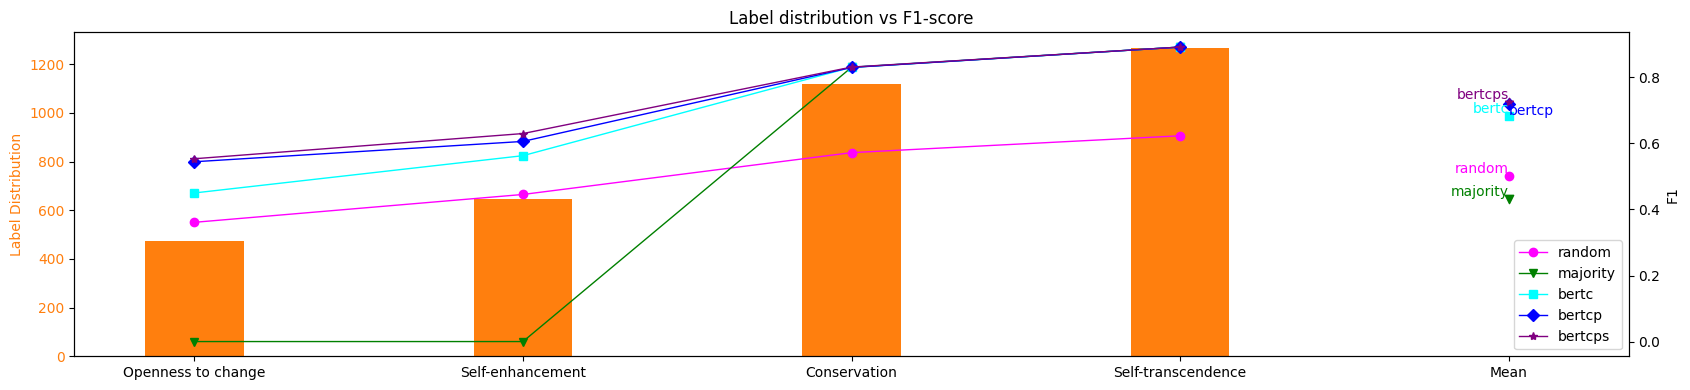

In [36]:
labels_count = list([x.item() for x in test_dataset.labels.sum(axis=0)]) + [0]
x_labels = TOUCHE_VALUES + ['Mean']
color_names = ['fuchsia', 'green', 'cyan', 'blue', 'purple']
markers = ['o', 'v', 's', 'D', '*']

fig, ax1 = plt.subplots(figsize=(17,4))
ax1.set_title(f'Label distribution vs F1-score')
color = 'tab:orange'
ax1.bar(x_labels, labels_count, color=color, width=0.3)
ax1.set_xticklabels(x_labels, rotation=0)
ax1.set_ylabel('Label Distribution', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
for model_name, color, marker in zip(list(results.keys()), color_names, markers):
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
    ax2.plot(TOUCHE_VALUES, model_results_best['f1s'], linewidth=1, marker=marker, color=color)
    ax2.set_ylabel('F1')
    ax2.tick_params(axis='y')
    fig.tight_layout()
plt.legend(list(results.keys()), loc='lower right')
for model_name, color, marker in zip(list(results.keys()), color_names, markers):
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
    ax2.scatter(x_labels[-1], model_results_best['macro_f1'], color=color, marker=marker)
    ax2.text(x_labels[-1], model_results_best['macro_f1'], model_name, ha='left' if model_name=='bertcp' else 'right', va='top' if model_name=='bertcp' else 'bottom', color=color, multialignment='left' if model_name=='bertcp' else 'right')
plt.show()


## Breakdown comparison for each of the best models on every class

In [37]:
for model_name in list(results.keys()):
    print(f'{f"Comparison for model: {model_name}":_^65}')
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
    model_summary = pd.DataFrame(index=TOUCHE_VALUES, columns=['Precision', 'Recall', 'F1'])
    for i, value_name in enumerate(TOUCHE_VALUES):
        model_summary.loc[value_name] = [
            round(precision_score(test_dataset.labels[:, i], model_results_best['all_outputs'][:, i] >= 0.5), 3),
            round(recall_score(test_dataset.labels[:, i], model_results_best['all_outputs'][:, i] >= 0.5), 3),
            round(model_results_best['f1s'][i],3)
        ]
    print(model_summary.head())
    print()

__________________Comparison for model: random___________________
                   Precision Recall     F1
Openness to change      0.29  0.477  0.361
Self-enhancement       0.407  0.491  0.445
Conservation           0.702  0.483  0.572
Self-transcendence     0.808  0.507  0.623

_________________Comparison for model: majority__________________
                   Precision Recall     F1
Openness to change       0.0    0.0    0.0
Self-enhancement         0.0    0.0    0.0
Conservation            0.71    1.0   0.83
Self-transcendence     0.805    1.0  0.892

___________________Comparison for model: bertc___________________
                   Precision Recall     F1
Openness to change     0.396  0.521   0.45
Self-enhancement        0.45  0.751  0.563
Conservation            0.71    1.0   0.83
Self-transcendence     0.805    1.0  0.892

__________________Comparison for model: bertcp___________________
                   Precision Recall     F1
Openness to change     0.601  0.498  0.544
Se

## Confusion matrices for each of the best models on every class

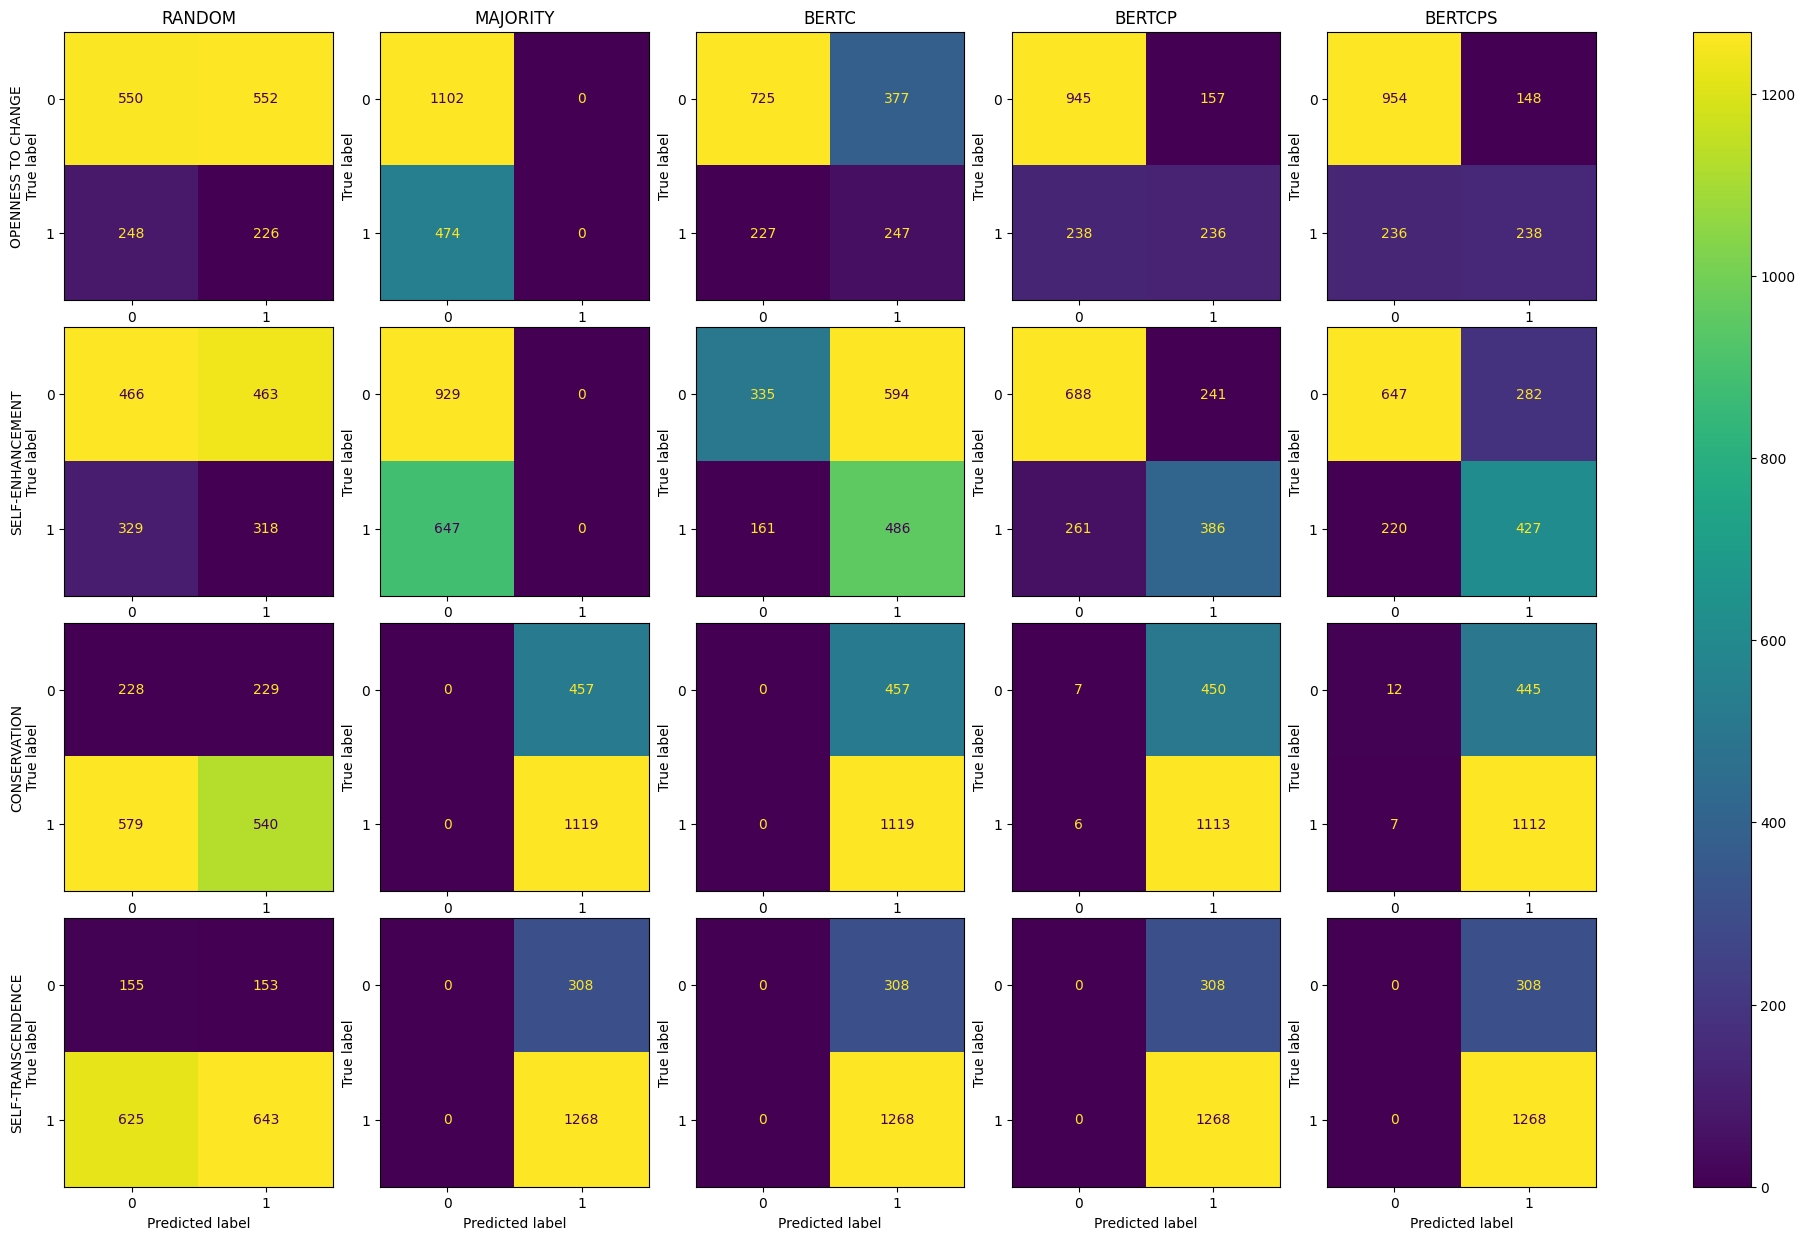

In [38]:
f, axes = plt.subplots(len(TOUCHE_VALUES), len(results), figsize=(25, 15))
axes = axes.ravel()
# plot a confusion matrix for each best model for each value

for i, value_name in enumerate(TOUCHE_VALUES):
    print()
    for j, model_name in enumerate(list(results.keys())):
        model_results_all = results[model_name]
        model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
        # print(f'Val: {value_name} - Model: {model_name} - F1s: {model_results_best["f1s"][i]} - argmax {np.argmax([x["macro_f1"] for x in model_results_all])}')
        cm = confusion_matrix(model_results_best['all_labels'][:, i], model_results_best['all_outputs'][:, i] >= 0.5)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
        ax_idx = i * len(results) + j
        disp.plot(ax=axes[ax_idx], values_format='d')
        if ax_idx < len(results):
            disp.ax_.set_title(f'{model_name.upper()}')
        if ax_idx % len(results) == 0:
            disp.ax_.set_ylabel(f"{value_name.upper()}\nTrue label")
        disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

### Inspecting the test dataset to reason upon the results obtained with the confusion matrices

In [39]:
train_all_labels = train_dataset.labels
ratio_train_labels = train_all_labels.sum(axis=0) / len(train_all_labels)
for v,p in zip(TOUCHE_VALUES, ratio_train_labels):
    print(f'Ratio for {v} in train set: {p*100:.2f}%')

Ratio for Openness to change in train set: 36.70%
Ratio for Self-enhancement in train set: 46.15%
Ratio for Conservation in train set: 76.15%
Ratio for Self-transcendence in train set: 76.12%


We can notice how the classes are unbalanced and this can explain the lazy behavior of the bert-based models

## Precision-Recall curve for the most misclassified class

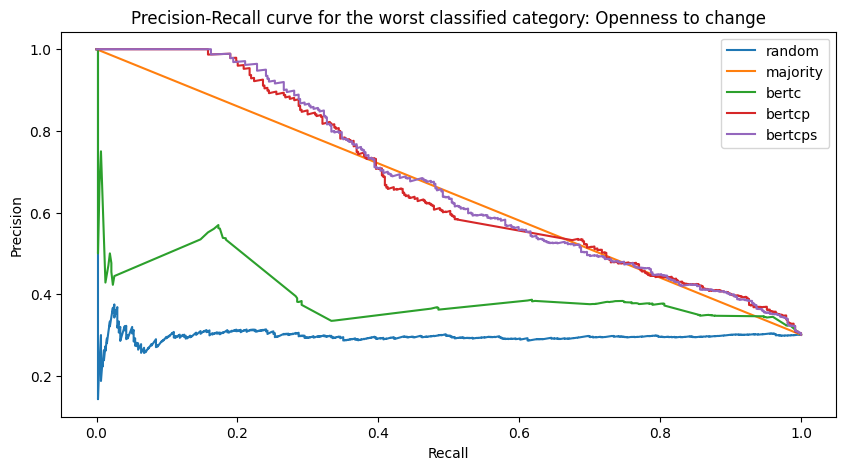

In [40]:
# computing precision-recall curve for each model on category with the lowest f1-score
coutner_worst = [0] * len(TOUCHE_VALUES)
for model_name in list(results.keys()):
    all_res = results[model_name]
    for res in all_res:
        f1s = res['f1s']
        min_argindex = np.argmin(f1s)
        coutner_worst[min_argindex] += 1
most_misclassified_category_index = np.argmax(coutner_worst)
most_misclassified_category = TOUCHE_VALUES[most_misclassified_category_index]

plt.figure(figsize=(10,5))
for model_name in list(results.keys()):
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmin([x['macro_f1'] for x in model_results_all])]
    # most_misclassified_category_index = np.argmin(model_results_best['f1s'])
    # most_misclassified_category = TOUCHE_VALUES[most_misclassified_category_index]
    precision, recall, _ = precision_recall_curve(model_results_best['all_labels'][:, most_misclassified_category_index], model_results_best['all_outputs'][:, most_misclassified_category_index])
    plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve for the worst classified category: {most_misclassified_category}')
plt.legend(list(results.keys()))
plt.show()

## Precision-Recall curve for the best classified class

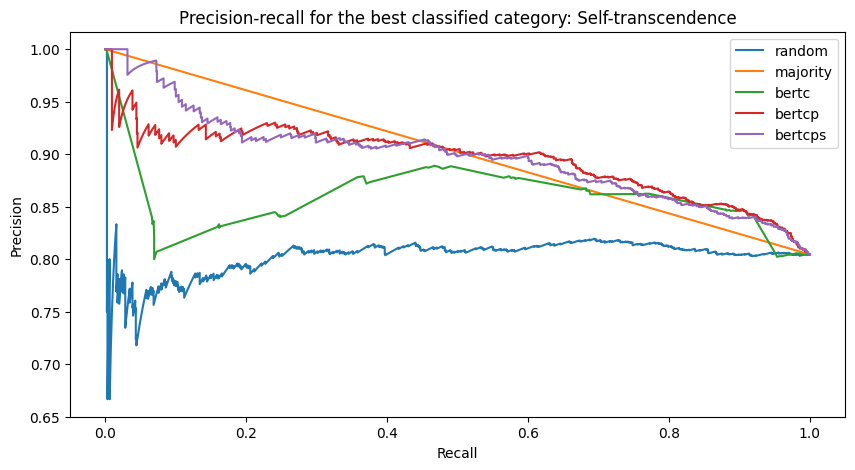

In [41]:
# computing precision-recall curve for each model on category with the highest f1-score
coutner_best = [0] * len(TOUCHE_VALUES)
for model_name in list(results.keys()):
    all_res = results[model_name]
    for res in all_res:
        f1s = res['f1s']
        max_argindex = np.argmax(f1s)
        coutner_best[max_argindex] += 1
most_classified_category_index = np.argmax(coutner_best)
most_classified_category = TOUCHE_VALUES[most_classified_category_index]

plt.figure(figsize=(10,5))
for model_name in list(results.keys()):
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
    # most_classified_category_index = np.argmax(model_results_best['f1s'])
    # most_classified_category = TOUCHE_VALUES[most_classified_category_index]
    precision, recall, _ = precision_recall_curve(model_results_best['all_labels'][:, most_classified_category_index], model_results_best['all_outputs'][:, most_classified_category_index])
    plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-recall for the best classified category: {most_classified_category}')
plt.legend(list(results.keys()))
plt.show()

## Precision-Recall curve for models on all predictions

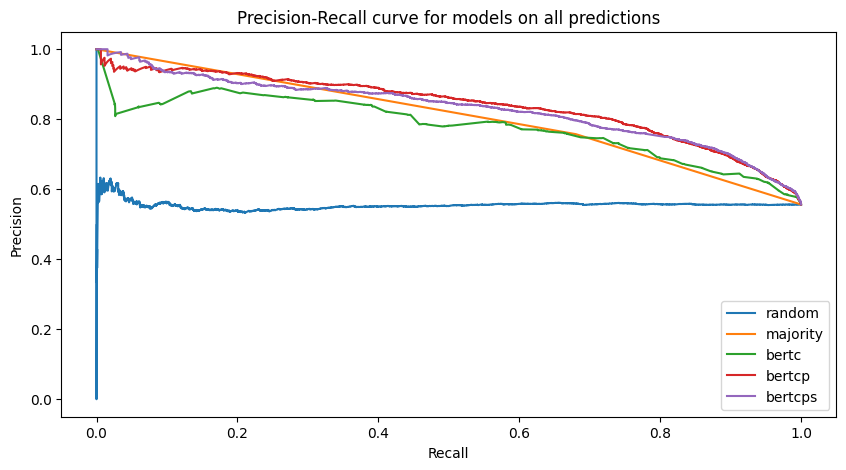

In [42]:
# computing precision-recall curve for each model on the macro f1 score
plt.figure(figsize=(10,5))
for model_name in list(results.keys()):
    model_results_all = results[model_name]
    model_results_best = model_results_all[np.argmax([x['macro_f1'] for x in model_results_all])]
    precision, recall, _ = precision_recall_curve(model_results_best['all_labels'].flatten(), model_results_best['all_outputs'].flatten())
    plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve for models on all predictions')
plt.legend(results.keys(), loc='lower right')
plt.show()

# [Task 6 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Model card

You are **free** to choose the BERT-base model card you like from huggingface.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Model Training

You are **free** to choose training hyper-parameters for BERT-based models (e.g., number of epochs, etc...).

### Neural Libraries

You are **free** to use any library of your choice to address the assignment (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

# The End